In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown

%matplotlib inline

In [2]:
os.listdir('.')

['.gitignore',
 '.ipynb_checkpoints',
 'chicago_crimes_eda.ipynb',
 'README.md',
 'Chicago_crimes.csv',
 '.git',
 'fbi_codes.csv']

In [3]:
df = pd.read_csv('Chicago_crimes.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,...,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [4]:
df.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

In [5]:
# remove unuseful columns and drop NaN it's about 10% of dataset
df.drop(['Case Number', 'Updated On', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
df.dropna(how='any', inplace=True)

In [6]:
df['Month'] = df['Date'].dt.month.astype('uint8')
df['Weekday'] = df['Date'].dt.weekday.astype('uint8')
df['Day'] = df['Date'].dt.day.astype('uint8')
# Block without house number
df['Only Block'] = df['Block'].str.extract('[0-9|X]* (.*)', expand=False)
df.drop(['Block'], axis=1, inplace=True)

In [7]:
# Fill unknown values and convert to less consumin datatype
dtypes = {'ID': 'uint32', 'Beat': 'uint16', 'Year': 'uint16', 'District': 'uint8', 'Ward': 'uint8', 
          'Community Area': 'uint8'}
for key, value in dtypes.items():
    df[key] = df[key].astype(value)

In [8]:
# Dataframe to map column 'FBI Code' and human readable description
if 'fbi_codes.csv' not in os.listdir('.'):
    fbi_df = pd.DataFrame({'Code': [], 'Description': [], 'Serious offense': []})
    temp = pd.read_html('http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html')
    # pattern that retrive desription and code
    pattern = re.compile(r' ([\w& -]*) (\(\d{2}[A-Z]?\))')
    # Retrive information about National Incident-Based Reporting System (NIBRS) codes
    # Crimes classified to less or more serious
    for i, serious_offense in enumerate([True, False]): 
        fbi_str = temp[0].iloc[3+i][1].replace('\xa0', ' ').replace('  ', ' ')
        fbi_list = pattern.findall(fbi_str)
        for desc, code in fbi_list:
            fbi_df = fbi_df.append(pd.DataFrame({'Code': [code[1:-1]], 'Description': [desc], 
                                                 'Serious offense': [serious_offense]}), ignore_index=True)
    fbi_df['Serious offense'] = fbi_df['Serious offense'].astype('bool')
    fbi_df.to_csv('fbi_codes.csv', index=False)
else:
    fbi_df = pd.read_csv('fbi_codes.csv', dtype={'Serious offense': 'bool'})

# Map of Chicago

In [9]:
# use for ignoring errors in coordinates
df['Longitude'].mean(), df['Longitude'].std(), df['Latitude'].mean(), df['Latitude'].std()

(-87.67183667212996,
 0.061425410282025014,
 41.84156879021282,
 0.08915885683457035)

In [10]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

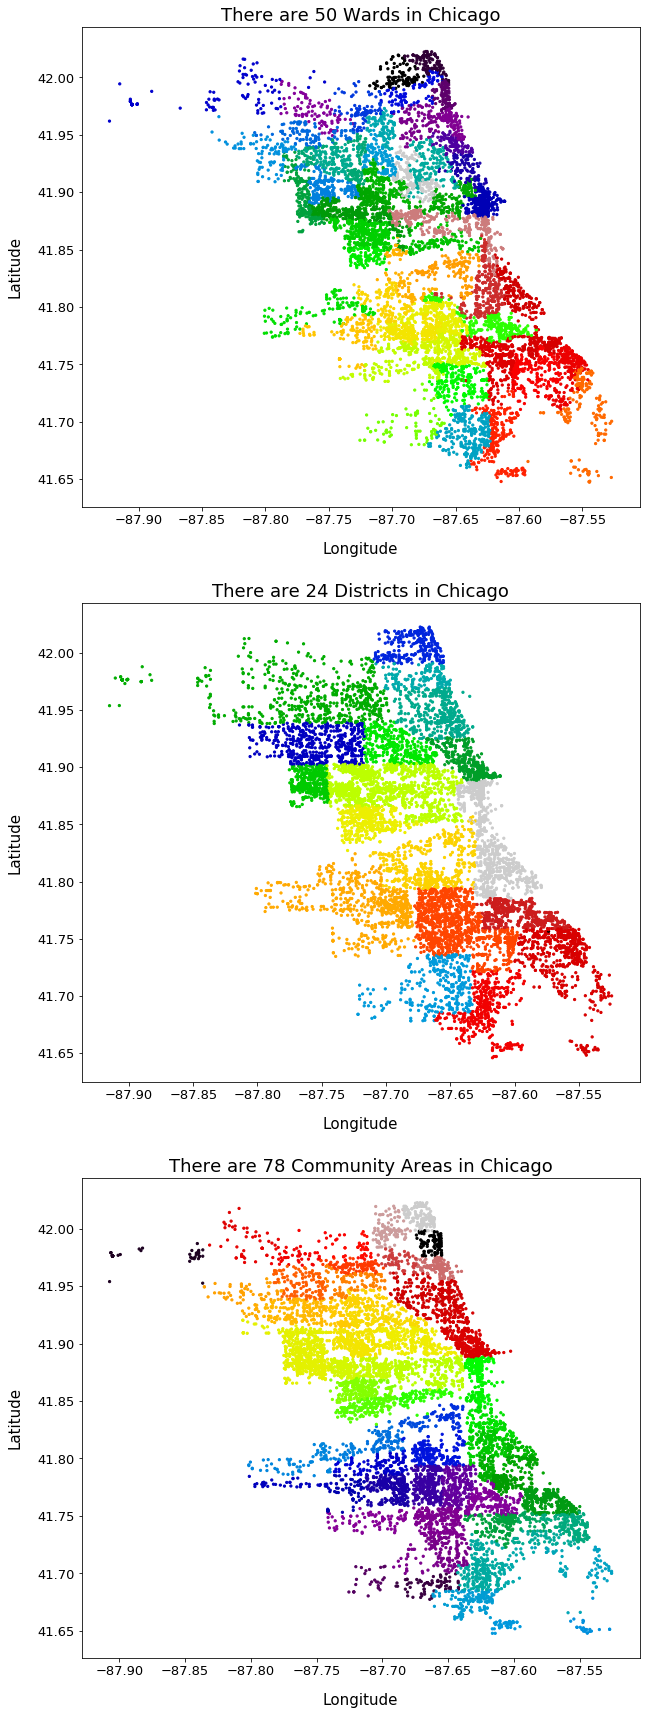

In [11]:
temp_list = ['Ward', 'District', 'Community Area']
fig, ax = plt.subplots(len(temp_list), 1)
n = 10
fig.set_figheight(n * len(temp_list))
fig.set_figwidth(n)

for i, column in enumerate(temp_list):
    temp = df[['Latitude', 'Longitude', column]].copy()

    # removing some anomalies
    temp = temp.loc[temp['Longitude'].between(-90, -85) & temp['Latitude'].between(39, 43), :]
    temp = temp.sample(10000)
    
    ax[i].scatter(temp['Longitude'], temp['Latitude'], c=temp[column], s=5, 
                cmap=discrete_cmap(df[column].nunique(), 'nipy_spectral_r'))
    ax[i].set_title('There are {} {}s in Chicago'.format(df[column].nunique(), temp_list[i]), 
                    fontdict={'fontsize': 18})
    ax[i].set_xlabel('Longitude', size=15, labelpad=15)
    ax[i].set_ylabel('Latitude', size=15, labelpad=15)
    ax[i].tick_params(labelsize=13)

In [12]:
temp = df['FBI Code'].value_counts().reset_index().merge(fbi_df, left_on='index', right_on='Code')\
.rename(columns={'FBI Code': 'counts'}).drop(['Code', 'index'], axis=1)
temp['pct'] = temp['counts'] / temp['counts'].sum()

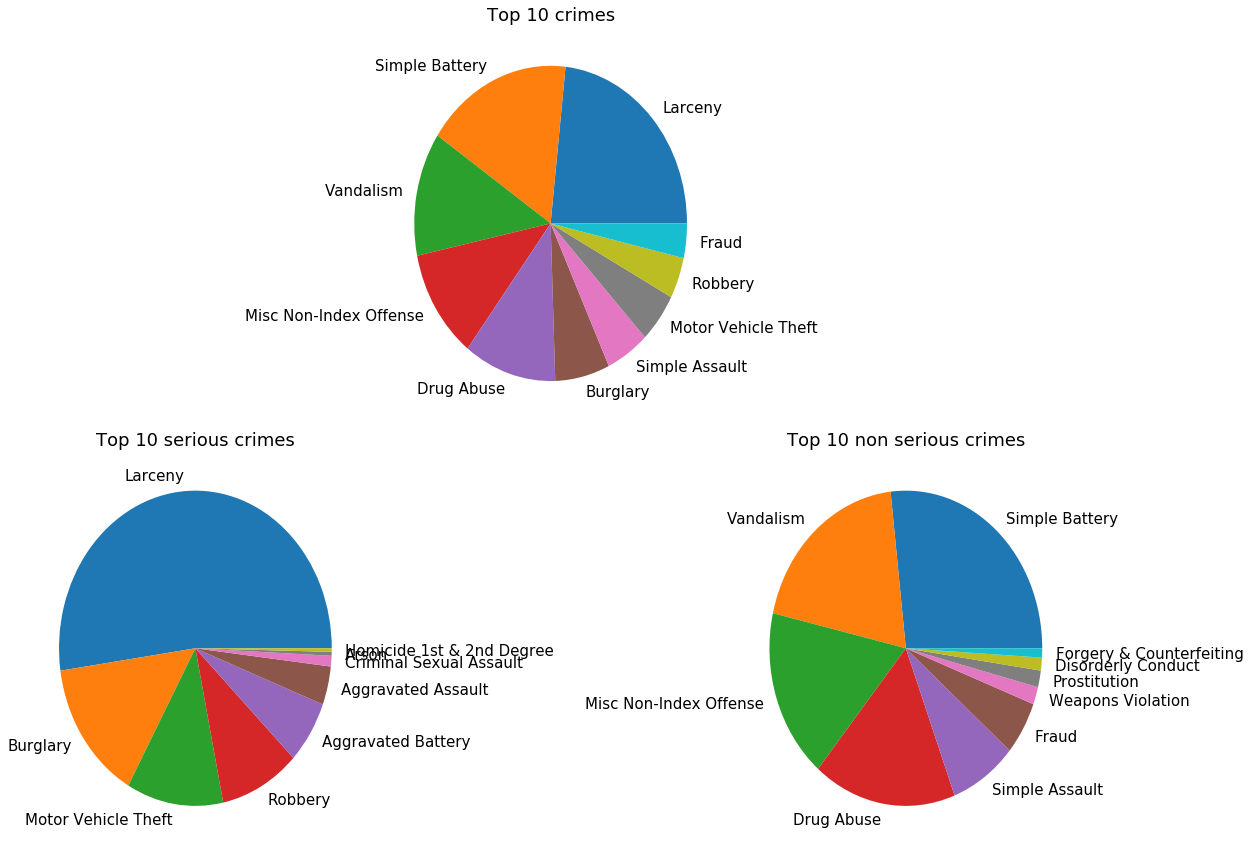

In [13]:
fig = plt.figure(figsize=(15, 12))

ax1 = plt.subplot2grid((2, 3), (0, 1))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 2))

wedges, texts = ax1.pie(x=temp['counts'].head(10), 
        labels=temp['Description'].head(10))

[text.set_size(15) for text in texts]
ax1.set_title('Top 10 crimes', fontdict={'fontsize': 18})

wedges, texts = ax2.pie(x=temp.loc[temp['Serious offense'] == True, 'counts'].head(10), 
        labels=temp.loc[temp['Serious offense'] == True, 'Description'].head(10))

[text.set_size(15) for text in texts]
ax2.set_title('Top 10 serious crimes', fontdict={'fontsize': 18})

wedges, texts = ax3.pie(x=temp.loc[temp['Serious offense'] == False, 'counts'].head(10), 
        labels=temp.loc[temp['Serious offense'] == False, 'Description'].head(10))

[text.set_size(15) for text in texts]
ax3.set_title('Top 10 non serious crimes', fontdict={'fontsize': 18})

plt.tight_layout()

In [14]:
temp = df['Location Description'].value_counts()
temp = temp * 100 / temp.sum()
temp = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct'})
temp.loc[temp['pct'] >= 1]\
.append({'Location': 'Total', 'pct': temp.loc[temp['pct'] >= 1, 'pct'].sum()}, ignore_index=True)

,Location,pct
0,STREET,25.897013
1,RESIDENCE,16.607430
2,APARTMENT,10.756872
3,SIDEWALK,10.297883
4,OTHER,3.716733
5,PARKING LOT/GARAGE(NON.RESID.),2.839955
6,ALLEY,2.253559
7,"SCHOOL, PUBLIC, BUILDING",2.113961
8,RESIDENCE-GARAGE,1.952159
9,SMALL RETAIL STORE,1.779204


In [15]:
temp = df.groupby(by=['FBI Code'])['Arrest'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Arrest']]
temp = temp.sort_values(by='Arrest')
temp = temp.append({'Description': 'Overall', 'Arrest': df['Arrest'].mean()}, ignore_index=True)

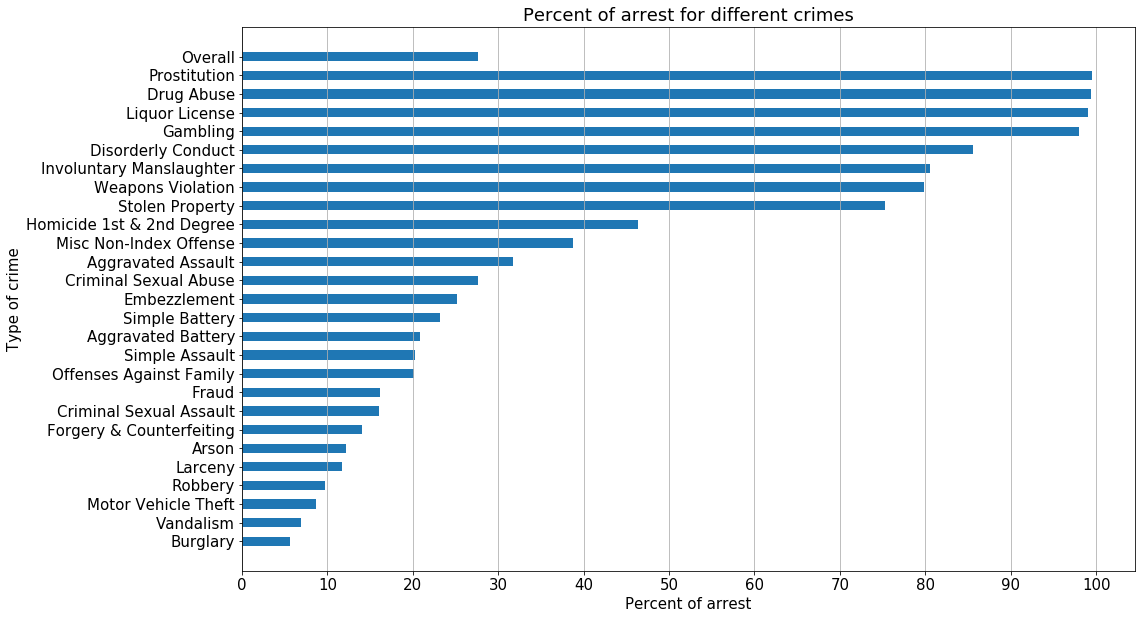

In [16]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Arrest'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of arrest for different crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of arrest', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 110, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

In [17]:
temp = df.groupby(by=['FBI Code'])['Domestic'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Domestic']]
temp = temp.sort_values(by='Domestic')
temp = temp.append({'Description': 'Overall', 'Domestic': df['Domestic'].mean()}, ignore_index=True)

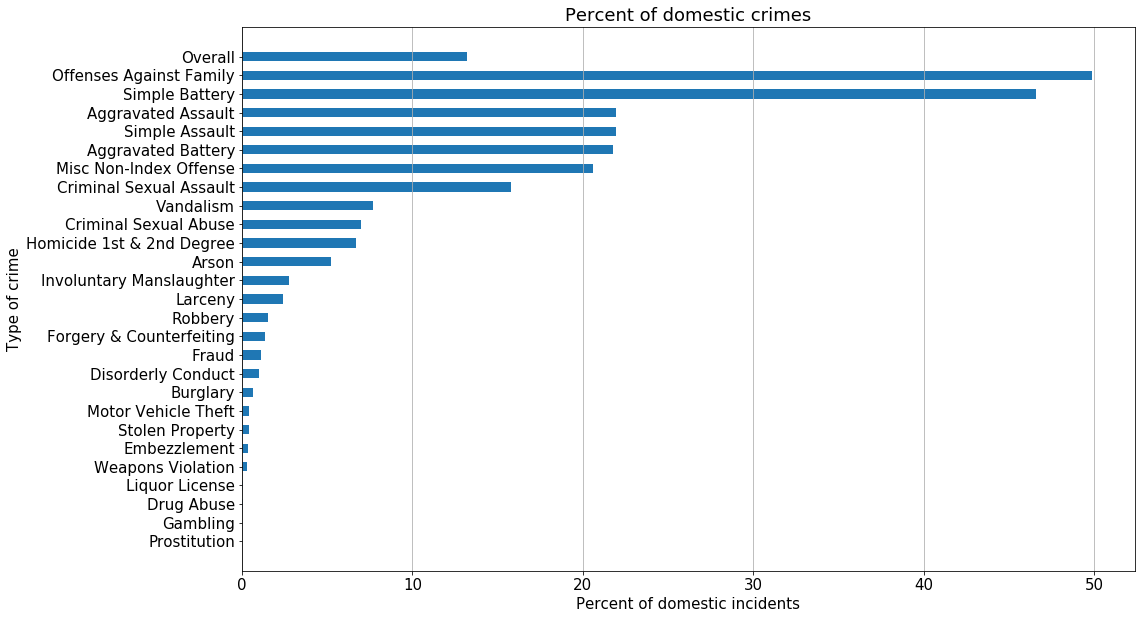

In [18]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Domestic'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of domestic crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of domestic incidents', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 60, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

### Most of incident isn't a domestic ones. Only 'Offenses Against Family' and 'Simple Battery' frequntly happen at home. Overall domestic incidents is only 13%.